In [1]:
import os
import json
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [15, 9]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


In [2]:
files = list(os.walk("../scrapy_projects/etoro/etoro/"))[0][2]


def load_investor_summary():
    etoro_sum_paths = [f for f in files if f.startswith("investor_dashboard")]
    with open(f"../scrapy_projects/etoro/etoro/{ sorted(etoro_sum_paths)[-1]}","r") as f:
        etoro_investor_sum = json.load(f)
        
    return etoro_investor_sum


def load_investor_portfolio():
    
    etoro_investor_paths = [f for f in files if f.startswith("investor_portfolio")]
    etoro_investors = []
    for path in etoro_investor_paths:
        with open(f"../scrapy_projects/etoro/etoro/{path}","r") as f:
            _ = json.load(f)
            etoro_investors.extend(_)


    investor_portfolio = []
    for investor in etoro_investors:
        for item in investor["items"]:
            row = {"investor_name":investor["investor_name"],
                        "date":investor["datetime"],
                        "company":item["company_ticker"],
                        "type":item["type"],
                        "invested":item["invested"].replace("<","").replace("%","")}
            investor_portfolio.append(row)
    return investor_portfolio


# Explore investor summary

In [3]:
investor_portfolio = load_investor_portfolio()
investor_summary = load_investor_summary()

investor_summary_df = pd.DataFrame(investor_summary)
df = pd.DataFrame(investor_portfolio)
df = df.astype({'invested': 'float32'})
df["date"] = pd.to_datetime(df["date"],format='%y-%m-%d')

investor_mapping = dict(zip(investor_summary_df["CustomerId"],investor_summary_df["UserName"]))
investor_summary_df = investor_summary_df.set_index("CustomerId")
investor_summary_df = investor_summary_df[['Gain', 'DailyGain', 'ThisWeekGain', 'RiskScore', 'MaxDailyRiskScore',
       'MaxMonthlyRiskScore', 'Copiers', 'CopyTradesPct', 'Trades', 'WinRatio',
       'DailyDD', 'WeeklyDD', 'ActiveWeeks']]

for col in investor_summary_df:
    investor_summary_df[col] = investor_summary_df[col].apply(lambda x: str(x).replace("$","").replace("+","").replace("M","")).astype(np.float32)

    
investor_summary = StandardScaler().fit_transform(investor_summary_df)



In [4]:
# distortions = []
# K = range(1,30)
# for k in tqdm(K):
#     kmeanModel = KMeans(n_clusters=k)
#     kmeanModel.fit(investor_summary_df)
#     distortions.append(kmeanModel.inertia_)

# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

In [5]:
kmeans = KMeans(25)
kmeans.fit(investor_summary)
investor_summary_df["k_means_cluster"] = kmeans.predict(investor_summary)


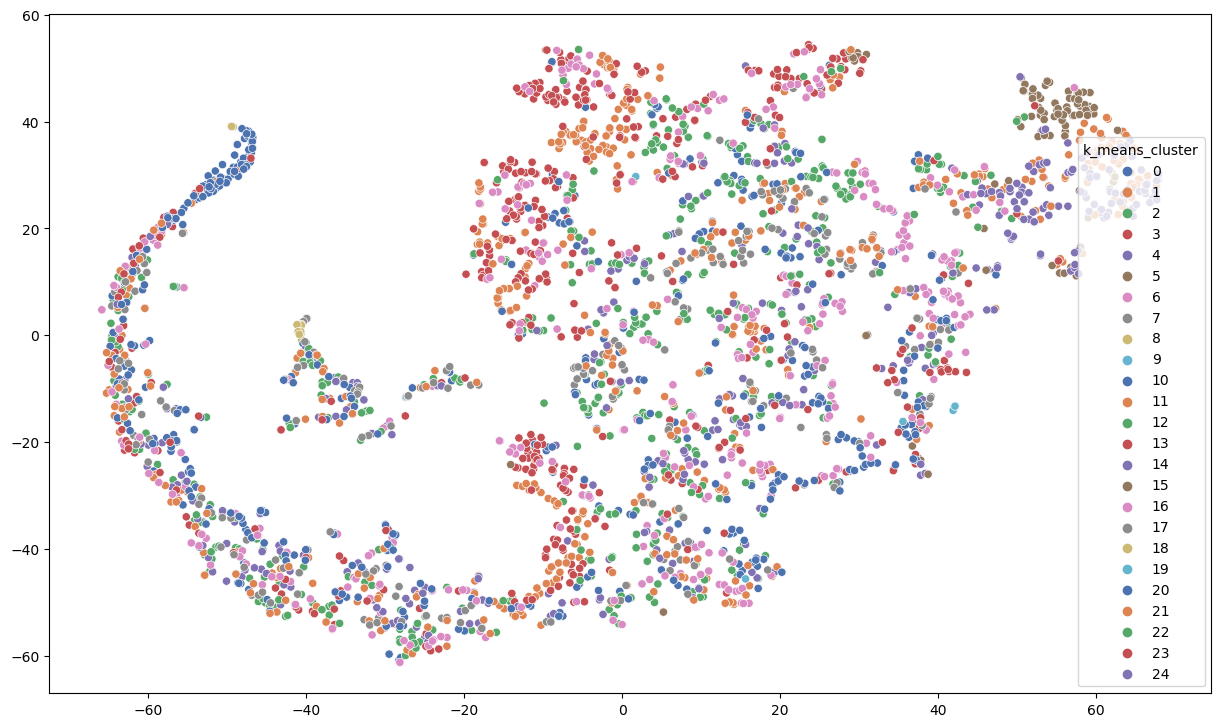

In [6]:
tsne = TSNE(n_components=2)
tsne_vals = tsne.fit_transform(investor_summary_df)

sns.scatterplot(x=tsne_vals[:,0],y=tsne_vals[:,1],hue=investor_summary_df["k_means_cluster"],palette="deep")

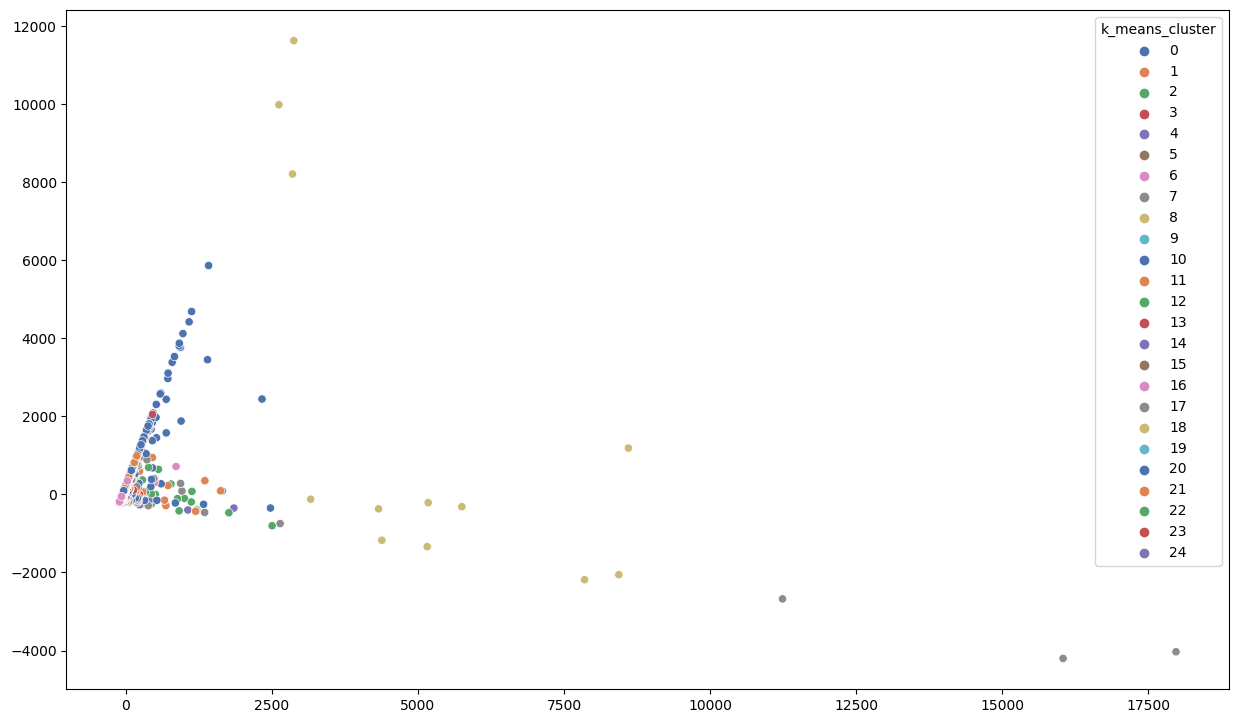

In [7]:
pca = PCA(n_components=2)
pca_vals = pca.fit_transform(investor_summary_df)

sns.scatterplot(x=pca_vals[:,0],y=pca_vals[:,1],hue=investor_summary_df["k_means_cluster"],palette="deep")

In [12]:
summ_all = investor_summary_df.groupby("k_means_cluster").mean()
summ_all["count"] = investor_summary_df.groupby("k_means_cluster")["k_means_cluster"].count()
summ_all

,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,count
k_means_cluster,,,,,,,,,,,,,,
0,91.207794,0.884814,-0.836746,5.254237,7.552542,5.905085,27.016949,2.803177,297.067810,71.578720,-7.720339,-10.908339,47.542374,295
1,32.140232,0.365907,0.029730,5.664093,6.602316,5.409266,5.362935,2.630645,166.606171,64.321457,-3.944402,-5.404479,14.884170,259
2,29.241785,0.435655,-0.637441,3.547619,5.220238,4.035714,92.696426,8.015057,185.226196,61.950809,-3.731488,-5.654286,53.863094,168
3,43.804768,5.112804,2.328972,6.168224,6.925234,5.551402,17.495327,5.861877,145.317764,69.158798,-7.434953,-8.815794,21.990654,107
4,49.400940,0.958205,-1.022906,4.230769,5.940171,4.923077,0.726496,80.271660,27.427351,32.227116,-6.894786,-10.464359,53.957264,117
5,5176.029785,0.100000,-1.020000,3.000000,5.000000,3.000000,2.000000,31.578947,19.000000,47.368420,-9.390000,-9.850000,19.000000,1
6,53.859344,1.390196,-0.928954,4.908497,6.248366,5.405229,11.888889,11.339849,132.529419,44.812531,-7.398039,-10.846340,53.960785,153
7,59.506664,0.810000,-0.173333,3.666667,6.000000,5.333333,15576.666992,0.000000,398.000000,73.424599,-5.396667,-7.793334,57.000000,3
8,81.750000,-0.840000,-1.553333,4.333333,6.000000,4.333333,328.333344,0.401313,10548.000000,70.371620,-4.993333,-8.330000,57.000000,3


In [13]:
gain_quantile = summ_all['Gain'].quantile(0.5)
risk_quantile = summ_all['RiskScore'].quantile(0.5)
win_quantile = summ_all['WinRatio'].quantile(0.5)
summ = summ_all[(summ_all['WinRatio']>win_quantile)&(summ_all['Gain']>gain_quantile)&(summ_all["RiskScore"]<risk_quantile)]
summ

,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,count
k_means_cluster,,,,,,,,,,,,,,
7,59.506664,0.81,-0.173333,3.666667,6.000000,5.333333,15576.666992,0.000000,398.000000,73.424599,-5.396667,-7.793334,57.000000,3
8,81.750000,-0.84,-1.553333,4.333333,6.000000,4.333333,328.333344,0.401313,10548.000000,70.371620,-4.993333,-8.330000,57.000000,3
18,80.545555,0.09,-0.943333,4.333333,6.333333,4.888889,5932.000000,0.008323,960.444458,70.996277,-5.906667,-8.023334,56.555557,9


In [14]:
print("Best clusters", summ.index.tolist())

Best clusters [7, 8, 18]


In [15]:
best_investors =investor_summary_df[investor_summary_df["k_means_cluster"].isin(summ.index.tolist())]
best_investors.sort_values("Gain",ascending=False)

,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,Trades,WinRatio,DailyDD,WeeklyDD,ActiveWeeks,k_means_cluster
CustomerId,,,,,,,,,,,,,,
11395358,149.139999,-2.40,-2.10,6.0,7.0,5.0,160.0,0.094778,10551.0,66.268600,-7.33,-14.14,57.0,8
6084415,137.000000,-1.44,3.21,4.0,7.0,5.0,3157.0,0.000000,888.0,58.445946,-4.37,-9.88,57.0,18
9996668,112.260002,-0.52,-4.44,5.0,7.0,6.0,4344.0,0.000000,933.0,63.987137,-6.70,-7.48,57.0,18
10501678,106.330002,0.18,-1.23,5.0,5.0,5.0,5388.0,0.000000,198.0,83.333336,-6.10,-9.27,57.0,18
5120021,81.739998,0.71,-1.39,5.0,8.0,5.0,8744.0,0.000000,304.0,72.368423,-6.59,-9.20,57.0,18
10383817,71.809998,1.57,-0.44,4.0,6.0,3.0,8111.0,0.000000,3488.0,71.961006,-6.12,-6.42,57.0,18
12023676,68.690002,-0.30,-3.03,4.0,6.0,5.0,6.0,1.097911,12205.0,76.788200,-4.37,-5.39,57.0,8
6253394,65.779999,-0.06,0.67,3.0,6.0,5.0,16642.0,0.000000,84.0,70.238098,-3.98,-4.36,57.0,7
9214186,61.880001,0.10,-1.63,3.0,6.0,6.0,8207.0,0.000000,36.0,100.000000,-8.96,-8.97,57.0,18


In [16]:
for investor_id in best_investors.index.values:
    print(investor_id, investor_mapping[investor_id])

5489903 rubymza
6253394 Richardstroud
10633478 Social-Investor
9629091 oceantan007
6084415 CanZhao
11839140 myhungetoro
12023676 DocPop
4356818 Wesl3y
5120021 hyjbrighter
9214186 SparkLiang
10383817 Miyoshi
10501678 ReturnInvest
3568542 misterg23
9996668 jianswang
11395358 cryptool


# Explore individual stocks

In [17]:
df.head()

,investor_name,date,company,type,invested
0,rubymza,2021-01-27,MSFT,Buying,5.48
1,rubymza,2021-01-27,MA,Buying,5.46
2,rubymza,2021-01-27,AMZN,Buying,4.16
3,rubymza,2021-01-27,NVDA,Buying,4.16
4,rubymza,2021-01-27,V,Buying,3.78


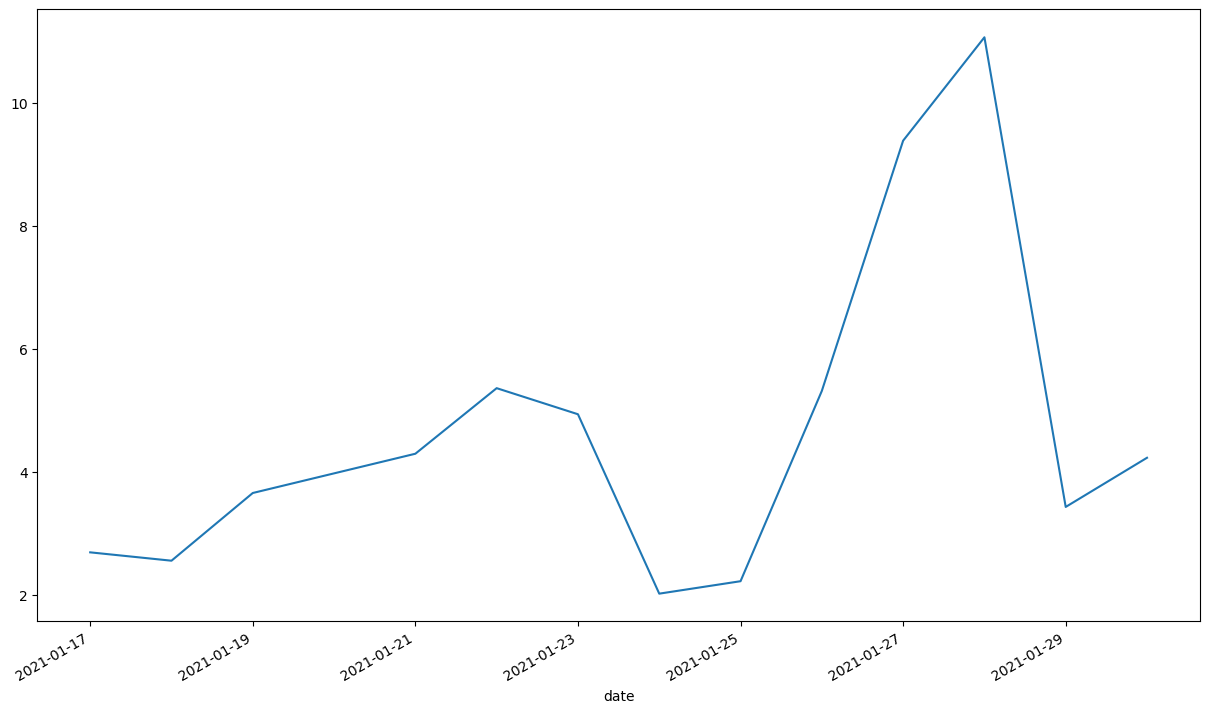

In [18]:
df[df.company=='GME'].groupby('date')['invested'].mean().plot()

In [19]:
dates = sorted(df.date.unique())
len(dates)

13

In [20]:
companies = df.company.unique()
len(companies)

2253

In [29]:
best_investor_stocks = df[df['investor_name'].isin([investor_mapping[i] for i in best_investors.index])]['company'].unique()

In [30]:
groupby = df.groupby(['company','date'])["invested"].mean()
idx = pd.IndexSlice
threshold = 1
chg_interest = list()
for stock_name in tqdm(best_investor_stocks):
    last_interest = groupby.to_frame().loc[idx[stock_name, dates[-threshold]:], :]
    last_interest_mean = last_interest.mean()

    historical_interest = groupby.to_frame().loc[idx[stock_name, :dates[-threshold-1]], :]
    historical_interest_mean = historical_interest.mean()

    vals = groupby.to_frame().loc[stock_name].values.reshape(-1)
    change_in_interest = (last_interest_mean/historical_interest_mean)[0]
    chg_interest.append((stock_name,change_in_interest,historical_interest_mean[0],last_interest_mean[0]))

100%|██████████| 230/230 [00:01<00:00, 164.98it/s]


In [33]:
TOP_N_CHANGE_IN_INTEREST_AMONG_BEST_INVESTORS = 10
chg_intrst = pd.DataFrame.from_records(chg_interest,columns=['stock','change_in_interest',"history","latest"]).sort_values('change_in_interest',ascending=False)
chg_intrst.head(TOP_N_CHANGE_IN_INTEREST_AMONG_BEST_INVESTORS)

,stock,change_in_interest,history,latest
220,PSLV,2.079464,1.236376,2.571000
197,SDOW,2.052413,2.619681,5.376667
200,NBIX,1.899065,2.613230,4.962692
128,BYD,1.788473,1.073542,1.920000
149,PENN,1.696304,1.041480,1.766667
226,BAH,1.649652,11.218124,18.505999
73,EW,1.635860,0.902278,1.476000
193,OLN,1.519503,1.474167,2.240000
116,PANW,1.493384,1.032172,1.541429
161,LYV,1.395337,1.677014,2.340000


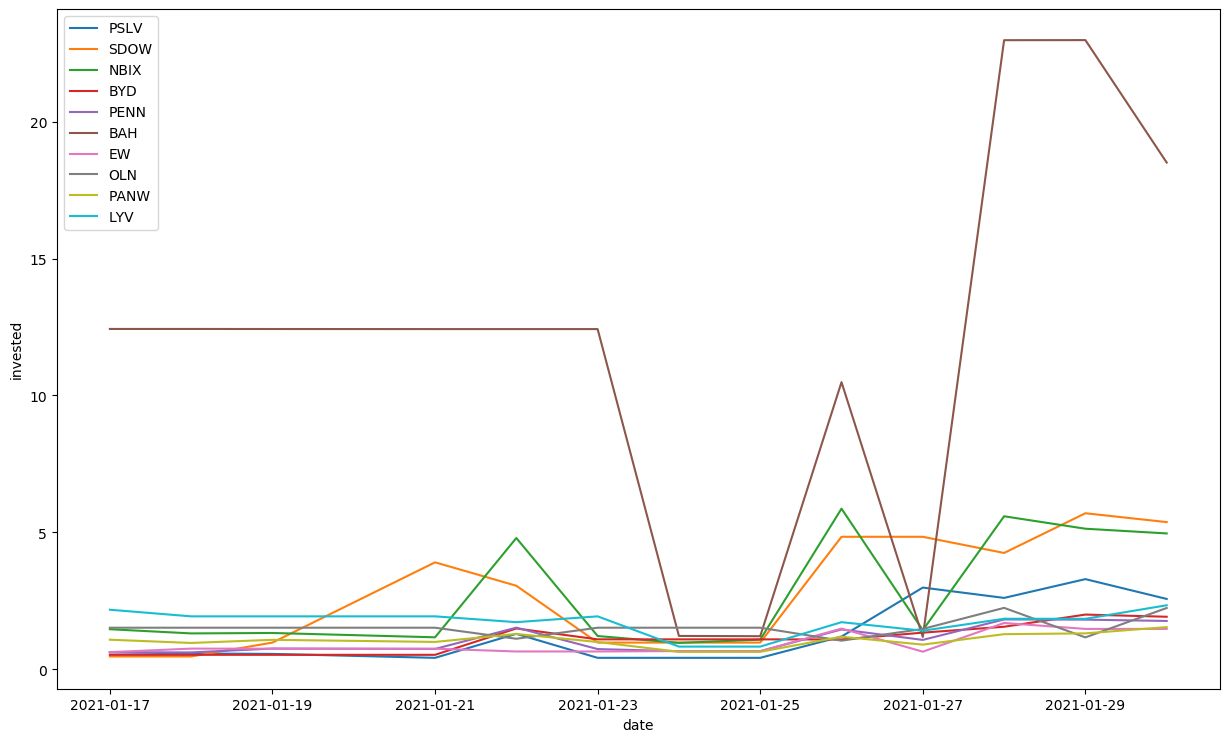

In [34]:
for int_stock in chg_intrst.head(TOP_N_CHANGE_IN_INTEREST_AMONG_BEST_INVESTORS)["stock"].values:
    vals = groupby.to_frame().loc[int_stock]
    sns.lineplot(y=vals["invested"],x=vals.index,label=int_stock)

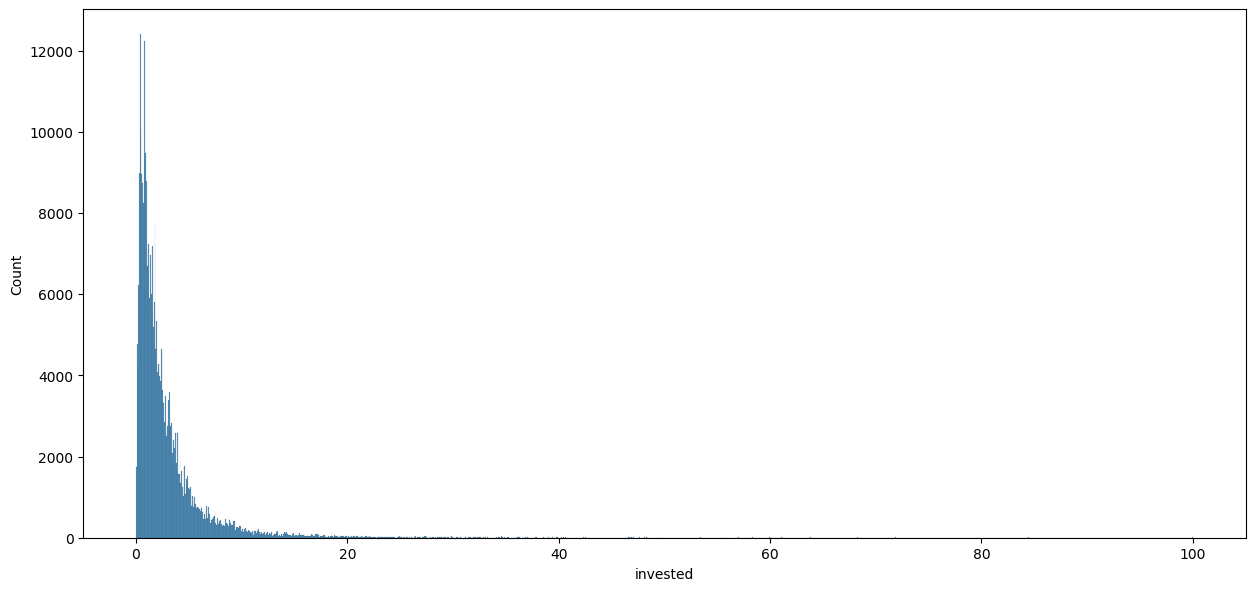

In [36]:
plt.figure(figsize=(15,7))
sns.histplot(df.invested)